# Question 2: Are there any routes on which rail leads to shorter journey times than air travel?

In [1]:
import collections
import os
import re

import folium
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from folium import FeatureGroup, LayerControl

In [2]:
DATA_DIR = "../../Data"

In [3]:
airport_indicators = pd.read_excel(os.path.join(DATA_DIR, "Airports_Indicators.xlsx"))
airport_rail_access = pd.read_excel(os.path.join(DATA_DIR, "Airports_Rail_Access.xlsx"))
alt_rail_routes_bidirectional = pd.read_excel(os.path.join(DATA_DIR, "Alternative_Rail_Routes_Bidirectional.xlsx"))
alt_rail_routes_unidirectional = pd.read_excel(os.path.join(DATA_DIR, "Alternative_Rail_Routes_Unidirectional.xlsx"))
candidate_rail_routes = pd.read_excel(os.path.join(DATA_DIR, "Candidate_Rail_Routes.xlsx"))

## Data Exploration

In [4]:
airport_indicators.head()

,Airport,IATA Code,Latitude,Longitude,Potential Passengers,Total Passengers,Connecting Passengers,Service ARISP,Theoretical ARISP,Delta ARISP
0,Aalborg Airport,AAL,57.086435,9.867982,58777,1460146,475826,6.751829e+03,1.373080e+04,6.978976e+03
1,Málaga-Costa del Sol Airport,AGP,36.678545,-4.499955,658614,20401883,2435885,1.160782e+05,2.157523e+05,9.967401e+04
2,Amsterdam Airport Schiphol,AMS,52.326980,4.741505,11181707,48283340,17605076,2.916196e+06,4.722534e+06,1.806338e+06
3,Marche Airport,AOI,43.617162,13.364858,8593,646447,81104,0.000000e+00,3.102980e+03,3.102980e+03
4,Stockholm-Arlanda Airport,ARN,59.646792,17.937044,2809610,20200389,5585200,5.152913e+05,8.919868e+05,3.766954e+05


In [5]:
airport_rail_access.columns = airport_rail_access.iloc[0]
airport_rail_access = airport_rail_access[1:]
airport_rail_access.head()

,Airport,IATA Code,Ptp Passengers,Spoke Passengers,Hub Passengers,Ptp Passengers [%],Spoke Passengers [%],Hub Passengers [%],Total Passengers,Generated Passengers,...,Detour Line,Branch Line,Linked to Line,High-Speed Rail,Long-distance,Regional/suburban,City-Airport Express Train,Train connection to City Station,Metro/Tram/ People Mover,Comments
1,Frankfurt Airport,FRA,21173848,6305886,15964490,0.48738,0.145149,0.367471,43444224,27479734,...,0,0,0,1,1,1,0,"ICE (12 min, nonstop)",0,NaN
2,Charles de Gaulle International Airport,CDG,32720275,9206483,11706349,0.610076,0.171657,0.218267,53633107,41926758,...,0,0,0,1,1,1,0,RER-B (31 min),0,NaN
3,Amsterdam Airport Schiphol,AMS,30678264,6169779,11435297,0.63538,0.127783,0.236837,48283340,36848043,...,0,0,0,1,1,1,0,"Intercity Direct (15 min, nonstop)",0,NaN
4,London Heathrow Airport,LHR,41329628,13195766,11295771,0.627908,0.200479,0.171613,65821165,54525394,...,0,1,0,0,0,1,1,"Heathrow Express (21 min, nonstop)",1,NaN
5,Madrid–Barajas Airport,MAD,32762382,5861990,9799351,0.676577,0.121056,0.202367,48423723,38624372,...,0,1,0,0,0,1,0,"Carcanias C1, C10 (19 min)",1,NaN


In [6]:
airport_rail_access.describe()

,Airport,IATA Code,Ptp Passengers,Spoke Passengers,Hub Passengers,Ptp Passengers [%],Spoke Passengers [%],Hub Passengers [%],Total Passengers,Generated Passengers,...,Detour Line,Branch Line,Linked to Line,High-Speed Rail,Long-distance,Regional/suburban,City-Airport Express Train,Train connection to City Station,Metro/Tram/ People Mover,Comments
count,318,318,318,318,318,318,318,318,318,318,...,318,318,318,318,318,318,318,318,318,9
unique,317,317,317,307,236,308,308,249,317,317,...,3,3,3,3,3,2,3,64,2,9
top,Düsseldorf Airport,DUS,14630079,0,0,1,0,0,18536792,18003273,...,-,-,-,-,-,-,-,-,0,MetroLink station planned to open in 2035
freq,2,2,2,10,69,10,10,69,2,2,...,234,234,234,234,234,234,255,255,281,1


In [7]:
alt_rail_routes_bidirectional.head()

,Bidirectional Route Name,Origin,Destination,Origin Coordinates,Destination Coordinates,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Passenger Flows,Theoretical ARISP,Service ARISP,Theoretical Time Difference,Service Time Difference,Theoretical Time Increase,Service Time Increase
0,A Coruña-AGP,A Coruña,AGP,"43.352681,-8.409651","36.677749,-4.490162",466.960144,471.064213,100.010468,162.016959,3613,1253.570094,1242.648572,-304.943185,-309.047254,188.216831,190.749942
1,A Coruña-BCN,A Coruña,BCN,"43.352681,-8.409651","41.304141,2.073126",456.163626,867.916176,104.935906,169.996167,34310,12786.132358,6720.197937,-286.167459,-697.920009,168.337595,410.550438
2,A Coruña-GVA,A Coruña,GVA,"43.352681,-8.409651","46.231334,6.110271",813.577093,964.708150,135.000000,218.700000,908,244.082094,205.844224,-594.877093,-746.008150,272.005987,341.110265
3,A Coruña-LGW,A Coruña,LGW,"43.352681,-8.409651","51.156735,-0.160922",885.255404,1250.218575,119.621596,193.786986,4996,1093.650236,774.392415,-691.468418,-1056.431589,356.818811,545.150947
4,A Coruña-MAD,A Coruña,MAD,"43.352681,-8.409651","40.492435,-3.592839",317.769684,273.757594,76.021220,123.154376,184030,71322.410288,82788.935567,-194.615308,-150.603218,158.025492,122.288158


In [8]:
alt_rail_routes_unidirectional.head()

,Route Name,Origin,Destination,Origin Coordinates,Destination Coordinates,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Theoretical Time Difference_MIN,Service Time Difference_MIN,Theoretical Time Difference_MAX,Service Time Difference_MAX,Theoretical Time Increase,Service Time Increase,Theoretical Time Increase_MIN,Service Time Increase_MIN,Theoretical Time Increase_MAX,Service Time Increase_MAX
0,A Coruña-AGP,A Coruña,Málaga-Costa del Sol Airport,"43.352681,-8.409651","36.677749,-4.490162",467.0,471.0,100.000000,162.000000,141.000000,...,-326.000000,-330.000000,-284.00000,-288.00000,188.271605,190.740741,231.205674,234.042553,155.191257,157.377049
1,A Coruña-BCN,A Coruña,Barcelona-El Prat Airport,"43.352681,-8.409651","41.304141,2.073126",473.0,845.0,100.000000,162.000000,141.000000,...,-332.000000,-704.000000,-290.00000,-662.00000,191.975309,421.604938,235.460993,499.290780,158.469945,361.748634
2,A Coruña-GVA,A Coruña,Geneva Cointrin International Airport,"43.352681,-8.409651","46.231334,6.110271",824.0,961.0,135.000000,218.700000,190.350000,...,-633.650000,-770.650000,-576.95000,-713.95000,276.771834,339.414723,332.886787,404.859469,233.535722,288.990083
3,A Coruña-LGW,A Coruña,London Gatwick Airport,"43.352681,-8.409651","51.156735,-0.160922",910.0,1241.0,117.979798,191.127273,166.351515,...,-743.648485,-1074.648485,-694.09697,-1025.09697,376.122527,549.305556,447.034392,646.010638,321.485515,474.795082
4,A Coruña-MAD,A Coruña,Madrid–Barajas Airport,"43.352681,-8.409651","40.492435,-3.592839",340.0,242.0,75.131711,121.713371,105.935712,...,-234.064288,-136.064288,-202.50897,-104.50897,179.344822,98.827785,220.949370,128.440434,147.288859,76.011482


In [9]:
candidate_rail_routes.head()

,Airport OD,Origin,Destination,Origin Coordinates,Destination Coordinates,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode
0,LHR-FAO,London Heathrow Airport,Faro,"51.472222,-0.487725","37.019187,-7.940261","Linha do Minho, Linha do Norte - Via Descendente","2973.7 km, 20 h 31 min",20:31:00,2973.7 km,-,-
1,FAO-LHR,Faro,London Heathrow Airport,"37.019187,-7.940261","51.472222,-0.487725","Linha do Sul, Madril-Hendaia trenbidea/Línea M...","2723.4 km, 23 h 32 min",23:32:00,2723.4 km,-,-
2,LHR-FLR,London Heathrow Airport,Firenze,"51.472222,-0.487725","43.77681,11.247806","Ligne de Combs-la-Ville à Saint-Louis (LGV), L...","1691.1 km, 8 h 19 min",08:19:00,1691.1 km,14h 56min,Train
3,FLR-LHR,Firenze,London Heathrow Airport,"43.77681,11.247806","51.472222,-0.487725","Ferrovia Milano-Bologna AV/AC, Ligne de Paris ...","1724.0 km, 8 h 31 min",08:31:00,1724.0 km,14h 45min,Train
4,LHR-LDY,London Heathrow Airport,Derry,"51.472222,-0.487725",NaN,-,-,-,-,-,-


## Derive routes where rail is faster than air
$\newline$
This is done via the already integrated columns `Service Time Difference` and `Theoretical Time Difference`

1. **Theoretical Time Difference**
    - It represents the time gain or loss a passenger would experience (in terms of perceived utility) if they switched from the air route to the best possible theoretical rail option.
    - Formula: \
    $\text{Theoretical Time Difference} = \text{Valued Air Travel Time} - \text{Rail Theoretical Travel Time}$
2. **Service Time Difference**
    - It represents the time gain or loss based on currently scheduled commercial rail services.
    - Formula: \
    $\text{Service Time Difference} = \text{Valued Air Travel Time} - \text{Rail Service Travel Time}$


**Note:** \
Both calculations use the Valued Air Travel Time (Air Travel Time $\times$ 1.62) rather than the raw flight duration. This accounts for the higher "disutility" (stress, discomfort, processing time) passengers typically associate with air travel compared to rail (BRUNO 2025).

In [10]:
# Valued Air travel Time - Rail Theoretical Travel Time
faster_rail_theoretical_valued = alt_rail_routes_unidirectional[
    alt_rail_routes_unidirectional['Theoretical Time Difference'] > 0]
num_faster_rail_theoretical_valued = len(faster_rail_theoretical_valued)
num_faster_rail_theoretical_valued

35

In [11]:
# Valued Air travel Time - Rail Service Travel Time
faster_rail_service_valued = alt_rail_routes_unidirectional[
    alt_rail_routes_unidirectional['Service Time Difference'] > 0]
num_faster_rail_service_valued = len(faster_rail_service_valued)
num_faster_rail_service_valued

1

In [12]:
examples = faster_rail_service_valued[
    ['Route Name', 'Origin', 'Destination', 'Rail Service Travel Time',
     'Valued Air Travel Time', 'Service Time Difference', 'Air Travel Time']].head(10)

print(f"Number of routes where Rail Service is faster than Valued Air: {num_faster_rail_service_valued}")
print(f"Number of routes where Rail Theoretical is faster than Valued Air: {num_faster_rail_theoretical_valued}")
print("\nExamples where Rail Service is faster than Valued Air:")
examples

Number of routes where Rail Service is faster than Valued Air: 1
Number of routes where Rail Theoretical is faster than Valued Air: 35

Examples where Rail Service is faster than Valued Air:


,Route Name,Origin,Destination,Rail Service Travel Time,Valued Air Travel Time,Service Time Difference,Air Travel Time
6373,Stuttgart-FRA,Stuttgart,Frankfurt Airport,71.0,81.0,10.0,50.0


## Check out route details

In [13]:
candidate_rail_routes.loc[
    (candidate_rail_routes['Origin'] == 'Stuttgart') & (candidate_rail_routes['Destination'] == 'Frankfurt Airport')]

,Airport OD,Origin,Destination,Origin Coordinates,Destination Coordinates,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode
2117,STR-FRA,Stuttgart,Frankfurt Airport,"48.784081,9.181636","50.052932,8.569915","Schnellfahrstrecke Mannheim–Stuttgart, Main-Ne...","182.1 km, 1 h 11 min",01:11:00,182.1 km,1h 11min,Train


## Check out theoretically faster rail routes

In [14]:
faster_rail_theoretical_valued[['Route Name', 'Origin', 'Destination', 'Rail Theoretical Travel Time',
                                'Valued Air Travel Time', 'Theoretical Time Difference']].head()

,Route Name,Origin,Destination,Rail Theoretical Travel Time,Valued Air Travel Time,Theoretical Time Difference
181,AMS-BRU,Amsterdam Airport Schiphol,Brussels Airport,66.0,73.576865,7.576865
194,AMS-Brussels,Amsterdam Airport Schiphol,Brussels,73.0,73.576865,0.576865
1171,BRU-AMS,Brussels Airport,Amsterdam Airport Schiphol,66.0,90.668465,24.668465
1176,BRU-Amsterdam,Brussels Airport,Amsterdam,77.0,90.668465,13.668465
1193,BRU-CDG,Brussels Airport,Charles de Gaulle International Airport,78.0,101.690722,23.690722


## Explore faster routes

- Display routes on map
- Show descriptive analysis of faster rail routes

In [15]:
# convert coordinates to readable format

faster_rail_theoretical_valued = faster_rail_theoretical_valued.copy()

def split_coords(coord_str):
    lat_str, lon_str = coord_str.split(',')
    return float(lat_str.strip()), float(lon_str.strip())

faster_rail_theoretical_valued['origin_lat'] = faster_rail_theoretical_valued['Origin Coordinates'].map(
    lambda x: split_coords(x)[0])
faster_rail_theoretical_valued['origin_lon'] = faster_rail_theoretical_valued['Origin Coordinates'].map(
    lambda x: split_coords(x)[1])
faster_rail_theoretical_valued['dest_lat'] = faster_rail_theoretical_valued['Destination Coordinates'].map(
    lambda x: split_coords(x)[0])
faster_rail_theoretical_valued['dest_lon'] = faster_rail_theoretical_valued['Destination Coordinates'].map(
    lambda x: split_coords(x)[1])

In [16]:
faster_rail_theoretical_valued.head()

,Route Name,Origin,Destination,Origin Coordinates,Destination Coordinates,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Theoretical Time Increase,Service Time Increase,Theoretical Time Increase_MIN,Service Time Increase_MIN,Theoretical Time Increase_MAX,Service Time Increase_MAX,origin_lat,origin_lon,dest_lat,dest_lon
181,AMS-BRU,Amsterdam Airport Schiphol,Brussels Airport,"52.309523,4.762181","50.898344,4.482370",66.0,131.0,45.417818,73.576865,64.039123,...,-10.297890,78.045097,3.061999,104.562452,-20.591575,57.613692,52.309523,4.762181,50.898344,4.482370
194,AMS-Brussels,Amsterdam Airport Schiphol,Brussels,"52.309523,4.762181","50.835374,4.335695",73.0,99.0,45.417818,73.576865,64.039123,...,-0.784030,34.553165,13.992817,54.592998,-12.169469,19.112638,52.309523,4.762181,50.835374,4.335695
1171,BRU-AMS,Brussels Airport,Amsterdam Airport Schiphol,"50.898344,4.482370","52.309523,4.762181",66.0,145.0,55.968188,90.668465,78.915145,...,-27.207326,59.923299,-16.365864,83.741663,-35.560584,41.571445,50.898344,4.482370,52.309523,4.762181
1176,BRU-Amsterdam,Brussels Airport,Amsterdam,"50.898344,4.482370","52.37919,4.899426",77.0,163.0,55.968188,90.668465,78.915145,...,-15.075214,79.775847,-2.426841,106.550973,-24.820681,59.145831,50.898344,4.482370,52.379190,4.899426
1193,BRU-CDG,Brussels Airport,Charles de Gaulle International Airport,"50.898344,4.482370","49.003989,2.571154",78.0,190.0,62.772050,101.690722,88.508591,...,-23.296837,86.841038,-11.872962,114.668427,-32.098839,65.400263,50.898344,4.482370,49.003989,2.571154


In [17]:
full_info_faster_rail_theoretical_valued = faster_rail_theoretical_valued.merge(
    candidate_rail_routes.drop_duplicates(subset=['Origin', 'Destination']),
    on=['Origin', 'Destination'],
    how='left'
)

### Clean travel times

In [18]:
def parse_row(time_str):
    if pd.isna(time_str) or time_str == "" or time_str == "nan":
        return pd.NaT

    clean_str = time_str.split(',')[-1]

    hours_match = re.search(r'(?i)(\d+)\s*h', clean_str)
    mins_match = re.search(r'(?i)(\d+)\s*min', clean_str)

    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(mins_match.group(1)) if mins_match else 0

    if hours == 0 and minutes == 0:
        return pd.NaT
    return pd.Timedelta(hours=hours, minutes=minutes)


In [19]:
full_info_faster_rail_theoretical_valued['Distance'] = full_info_faster_rail_theoretical_valued['Distance'].str[
    :-3].astype(float)
full_info_faster_rail_theoretical_valued['Theoretical Travel Time'] = full_info_faster_rail_theoretical_valued[
    'Distance and Theoretical Time'].apply(parse_row)
full_info_faster_rail_theoretical_valued['Service Travel Time'] = full_info_faster_rail_theoretical_valued[
    'Service Travel Time'].apply(parse_row)
full_info_faster_rail_theoretical_valued['Travel Time Delta'] = full_info_faster_rail_theoretical_valued[
                                                                    'Service Travel Time'] - \
                                                                full_info_faster_rail_theoretical_valued[
                                                                    'Theoretical Travel Time']

In [20]:
full_info_faster_rail_theoretical_valued

,Route Name,Origin,Destination,Origin Coordinates_x,Destination Coordinates_x,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Airport OD,Origin Coordinates_y,Destination Coordinates_y,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode,Travel Time Delta
0,AMS-BRU,Amsterdam Airport Schiphol,Brussels Airport,"52.309523,4.762181","50.898344,4.482370",66.0,131.0,45.417818,73.576865,64.039123,...,AMS-BRU,"52.309523,4.762181","50.898344,4.482370","HSL-Zuid, L25","185.8 km, 1 h 6 min",0 days 01:06:00,185.8,0 days 02:11:00,Train,0 days 01:05:00
1,AMS-Brussels,Amsterdam Airport Schiphol,Brussels,"52.309523,4.762181","50.835374,4.335695",73.0,99.0,45.417818,73.576865,64.039123,...,AMS-BRU,"52.309523,4.762181","50.835374,4.335695","HSL-Zuid, L25","195.1 km, 1 h 13 min",0 days 01:13:00,195.1,0 days 01:39:00,Train,0 days 00:26:00
2,BRU-AMS,Brussels Airport,Amsterdam Airport Schiphol,"50.898344,4.482370","52.309523,4.762181",66.0,145.0,55.968188,90.668465,78.915145,...,BRU-AMS,"50.898344,4.482370","52.309523,4.762181","L25, HSL-Zuid","185.8 km, 1 h 6 min",0 days 01:06:00,185.8,0 days 02:25:00,Train,0 days 01:19:00
3,BRU-Amsterdam,Brussels Airport,Amsterdam,"50.898344,4.482370","52.37919,4.899426",77.0,163.0,55.968188,90.668465,78.915145,...,BRU-AMS,"50.898344,4.482370","52.37919,4.899426","L25, HSL-Zuid","202.7 km, 1 h 17 min",0 days 01:17:00,202.7,0 days 02:43:00,Train,0 days 01:26:00
4,BRU-CDG,Brussels Airport,Charles de Gaulle International Airport,"50.898344,4.482370","49.003989,2.571154",78.0,190.0,62.772050,101.690722,88.508591,...,BRU-CDG,"50.898344,4.482370","49.003989,2.571154","L1, Ligne de Gonesse à Lille-Frontière (LGV)","306.5 km, 1 h 18 min",0 days 01:18:00,306.5,0 days 03:10:00,Train,0 days 01:52:00
5,BRU-London,Brussels Airport,London,"50.898344,4.482370","51.531921,-0.126361",111.0,204.0,73.865306,119.661796,104.150082,...,BRU-LHR,"50.898344,4.482370","51.531921,-0.126361","Ligne de Fretin à Frethun (LGV), High Speed 1","387.7 km, 1 h 51 min",0 days 01:51:00,387.7,0 days 03:24:00,Train,0 days 01:33:00
6,BRU-Paris,Brussels Airport,Paris,"50.898344,4.482370","48.8804,2.354973",87.0,125.0,62.772050,101.690722,88.508591,...,BRU-CDG,"50.898344,4.482370","48.8804,2.354973","L1, Ligne de Gonesse à Lille-Frontière (LGV)","328.6 km, 1 h 27 min",0 days 01:27:00,328.6,0 days 02:05:00,Train,0 days 00:38:00
7,Brussels-AMS,Brussels,Amsterdam Airport Schiphol,"50.835374,4.335695","52.309523,4.762181",74.0,97.0,55.968188,90.668465,78.915145,...,BRU-AMS,"50.835374,4.335695","52.309523,4.762181","L25, HSL-Zuid","196.7 km, 1 h 14 min",0 days 01:14:00,196.7,0 days 01:37:00,Train,0 days 00:23:00
8,Brussels-CDG,Brussels,Charles de Gaulle International Airport,"50.835374,4.335695","49.003989,2.571154",64.0,107.0,62.772050,101.690722,88.508591,...,BRU-CDG,"50.835374,4.335695","49.003989,2.571154","L1, Ligne de Gonesse à Lille-Frontière (LGV)","291.0 km, 1 h 4 min",0 days 01:04:00,291.0,0 days 01:47:00,Train,0 days 00:43:00
9,CDG-BRU,Charles de Gaulle International Airport,Brussels Airport,"49.003989,2.571154","50.898344,4.482370",75.0,197.0,59.495413,96.382569,83.888532,...,CDG-BRU,"49.003989,2.571154","50.898344,4.482370","Ligne de Gonesse à Lille-Frontière (LGV), L1","307.0 km, 1 h 15 min",0 days 01:15:00,307.0,0 days 03:17:00,Train,0 days 02:02:00


In [21]:
df = full_info_faster_rail_theoretical_valued.copy()

all_origins = set(df['Origin'])
all_destinations = set(df['Destination'])
hub_stations = all_origins.intersection(all_destinations)

m = folium.Map(location=[50.8503, 4.3517], zoom_start=6, tiles='CartoDB positron')
routes_layer = FeatureGroup(name="Connections")
stations_layer = FeatureGroup(name="Stations")

plotted_cities = set()
tooltip_style = "font-size: 14px; font-weight: bold; white-space: nowrap;"


def add_station_marker(name, coords, role_color, role_icon, role_label):
    """Adds a marker if the station hasn't been plotted yet."""
    if name in plotted_cities:
        return

    if name in hub_stations:
        color, icon, label_suffix = 'purple', 'exchange', 'Hub'
    else:
        color, icon, label_suffix = role_color, role_icon, role_label

    folium.Marker(
        location=coords,
        tooltip=folium.Tooltip(f"{name} ({label_suffix})", style=tooltip_style),
        icon=folium.Icon(color=color, icon=icon, prefix='fa')
    ).add_to(stations_layer)

    plotted_cities.add(name)


for _, row in df.iterrows():
    p1 = (row['origin_lat'], row['origin_lon'])
    p2 = (row['dest_lat'], row['dest_lon'])

    info_text = (f"{row['Origin']} to {row['Destination']}: "
                 f"Rail {row['Rail Theoretical Travel Time']} min, "
                 f"Air {round(row['Valued Air Travel Time'], 2)} min, "
                 f"Distance {row['Distance']} km")

    folium.PolyLine(
        locations=[p1, p2],
        color='blue', weight=2, opacity=0.5,
        tooltip=folium.Tooltip(info_text, style=tooltip_style)
    ).add_to(routes_layer)

    add_station_marker(row['Origin'], p1, 'green', 'train', 'Origin')
    add_station_marker(row['Destination'], p2, 'red', 'home', 'Destination')

routes_layer.add_to(m)
stations_layer.add_to(m)
LayerControl().add_to(m)

m.save("map_osm.html")
print("Map saved as 'map_osm.html'. Open this file in your browser.")
m

Map saved as 'map_osm.html'. Open this file in your browser.


## Descriptive analysis of faster routes

In [22]:
analysis_df = full_info_faster_rail_theoretical_valued.copy()

In [23]:
num_routes = len(analysis_df)
routes_service_faster = analysis_df[analysis_df['Service Time Difference'] > 0]
num_service_faster = len(routes_service_faster)
pct_service_faster = (num_service_faster / num_routes) * 100

In [24]:
print(f"Total Routes in file: {num_routes}")
print(f"Routes where Current Rail Service is faster than Valued Air: {num_service_faster} ({pct_service_faster:.1f}%)")

Total Routes in file: 35
Routes where Current Rail Service is faster than Valued Air: 1 (2.9%)


In [25]:
# 2. Descriptive Stats on Time Differences
print("\nDescriptive Statistics for Time Differences (Minutes):")
analysis_df[['Theoretical Time Difference', 'Service Time Difference', "Distance", "Theoretical Travel Time",
             'Service Travel Time', 'Travel Time Delta']].describe()


Descriptive Statistics for Time Differences (Minutes):


,Theoretical Time Difference,Service Time Difference,Distance,Theoretical Travel Time,Service Travel Time,Travel Time Delta
count,35.000000,34.000000,35.000000,35,34,34
mean,14.367565,-47.362800,309.217143,0 days 01:22:30.857142857,0 days 02:24:14.117647058,0 days 01:02:07.058823529
std,9.605683,33.989444,103.932030,0 days 00:17:57.189620722,0 days 00:39:52.308530886,0 days 00:34:14.109745101
min,0.100000,-110.370909,182.100000,0 days 00:55:00,0 days 01:11:00,0 days 00:00:00
25%,8.119330,-73.585243,208.600000,0 days 01:06:00,0 days 01:53:15,0 days 00:33:30
50%,13.668465,-50.050616,306.500000,0 days 01:18:00,0 days 02:20:30,0 days 00:57:30
75%,21.195858,-16.329323,411.600000,0 days 01:38:00,0 days 02:56:45,0 days 01:31:15
max,37.690722,10.000000,487.100000,0 days 01:52:00,0 days 03:44:00,0 days 02:02:00


In [ ]:
# passenger Flows
total_passengers = analysis_df['Passenger Flows'].sum()
print(f"Total Annual Passenger Flow on these routes: {total_passengers:,}")

Total Annual Passenger Flow on these routes: 1,716,319


In [27]:
# 4. Top 5 Routes by Theoretical Time Difference (Best Potential)
print("Top 5 Routes by Theoretical Time Advantage:")
analysis_df.sort_values(by='Theoretical Time Difference', ascending=False)[
    ['Route Name', 'Theoretical Time Difference', 'Service Time Difference']].head(5)

Top 5 Routes by Theoretical Time Advantage:


,Route Name,Theoretical Time Difference,Service Time Difference
8,Brussels-CDG,37.690722,-5.309278
10,CDG-Brussels,32.382569,-68.617431
18,Düsseldorf-FRA,26.009147,-0.990853
21,FRA-Düsseldorf,25.186343,-73.813657
25,LYS-Marseille,24.846879,-10.153121


In [28]:
# 5. Top 5 Routes by Passenger Flow
print("Top 5 Routes by Passenger Flow:")
analysis_df.sort_values(by='Passenger Flows', ascending=False)[
    ['Route Name', 'Passenger Flows', 'Service Time Difference', 'Theoretical Time Difference']].head(5)

Top 5 Routes by Passenger Flow:


,Route Name,Passenger Flows,Service Time Difference,Theoretical Time Difference
29,Lyon-CDG,237145,-14.899953,16.100047
14,CDG-Lyon,190573,-74.514831,9.485169
34,Stuttgart-FRA,164025,10.000000,10.000000
28,London-CDG,136099,-51.201232,15.798768
21,FRA-Düsseldorf,120161,-73.813657,25.186343


## Plot 1: Histogram of Theoretical vs Service Time Difference

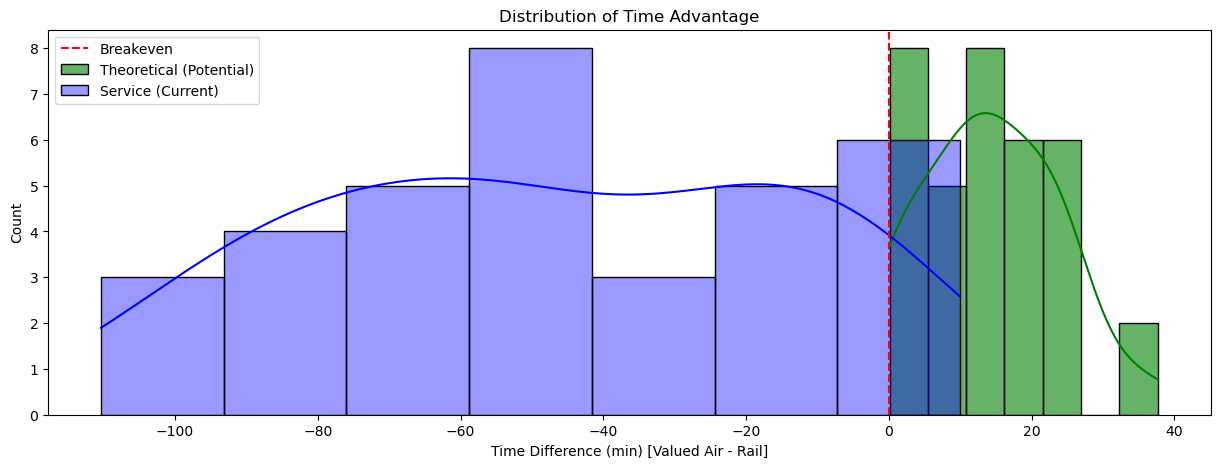

In [29]:
plt.figure(figsize=(15, 5))
sns.histplot(analysis_df['Theoretical Time Difference'], color='green', label='Theoretical (Potential)', kde=True,
             alpha=0.6)
sns.histplot(analysis_df['Service Time Difference'], color='blue', label='Service (Current)', kde=True, alpha=0.4)
plt.axvline(0, color='red', linestyle='--', label='Breakeven')
plt.xlabel("Time Difference (min) [Valued Air - Rail]")
plt.title("Distribution of Time Advantage")
plt.legend()

## Analysis by country
\
Load country mapping file and analyze routes by country:
- Total endpoints by country
- Domestic vs International routes

\
**note**\
Mapping file was created by Gemini 3 Pro

In [30]:
map_df = pd.read_csv(os.path.join(DATA_DIR,'Airport_Country_Map.csv',))
exact_matches = map_df[map_df['Type'] == 'Exact Match'].set_index('Airport_Name')['Country'].to_dict()
keyword_matches = map_df[map_df['Type'] == 'Keyword Match'][['Airport_Name', 'Country']].values.tolist()

In [31]:
def get_country_from_map(name):
    if not isinstance(name, str):
        return "Unknown"
    name = name.strip()
    if name in exact_matches:
        return exact_matches[name]
    for keyword, country in keyword_matches:
        if keyword in name:
            return country

    return "Unknown"

In [32]:
analysis_df['Origin Country'] = analysis_df['Origin'].apply(get_country_from_map)
analysis_df['Destination Country'] = analysis_df['Destination'].apply(get_country_from_map)

unknowns = analysis_df[(analysis_df['Origin Country'] == 'Unknown') | (analysis_df['Destination Country'] == 'Unknown')]
if not unknowns.empty:
    print("Warning: Some locations still unknown:")
    print(unknowns[['Origin', 'Destination']].head())

In [33]:
country_counts = collections.Counter()
for index, row in analysis_df.iterrows():
    country_counts[row['Origin Country']] += 1
    country_counts[row['Destination Country']] += 1

country_stats = pd.DataFrame.from_dict(country_counts, orient='index', columns=['Total Endpoints']).sort_values('Total Endpoints', ascending=False)

analysis_df['Type'] = analysis_df.apply(lambda x: 'Domestic' if x['Origin Country'] == x['Destination Country'] else 'International', axis=1)

domestic_stats = analysis_df[analysis_df['Type'] == 'Domestic']['Origin Country'].value_counts().to_frame(name='Domestic Routes')

final_stats = country_stats.join(domestic_stats).fillna(0)
final_stats['Domestic Routes'] = final_stats['Domestic Routes'].astype(int)

print("Country Analysis Results:")
print(final_stats)

print("\nTop 3 Countries Breakdown:")
top_3 = final_stats.head(3).index.tolist()
for country in top_3:
    print(f"\n--- {country} ---")
    involved_routes = analysis_df[(analysis_df['Origin Country'] == country) | (analysis_df['Destination Country'] == country)]
    print(f"Total Routes Involved: {len(involved_routes)}")

    domestic_routes = analysis_df[(analysis_df['Origin Country'] == country) & (analysis_df['Destination Country'] == country)]
    print(f"Domestic Routes: {len(domestic_routes)}")
    if not domestic_routes.empty:
        print(f"Examples: {domestic_routes['Origin'].tolist()[:3]} -> {domestic_routes['Destination'].tolist()[:3]}")

    international_routes = analysis_df[((analysis_df['Origin Country'] == country) & (analysis_df['Destination Country'] != country)) | ((analysis_df['Origin Country'] != country) & (analysis_df['Destination Country'] == country))]
    print(f"International Routes: {len(international_routes)}")
    other_countries = set(international_routes['Origin Country'].tolist() + international_routes['Destination Country'].tolist())
    if country in other_countries: other_countries.remove(country)
    print(f"Connected to: {', '.join(other_countries)}")

Country Analysis Results:
                Total Endpoints  Domestic Routes
France                       28                9
Germany                      15                7
Belgium                      13                0
Netherlands                   5                0
United Kingdom                4                0
Italy                         4                2
Luxembourg                    1                0

Top 3 Countries Breakdown:

--- France ---
Total Routes Involved: 19
Domestic Routes: 9
Examples: ['Charles de Gaulle International Airport', 'Charles de Gaulle International Airport', 'Charles de Gaulle International Airport'] -> ['Lyon Saint-Exupéry Airport', 'Lyon', 'Rennes']
International Routes: 10
Connected to: Belgium, Luxembourg, Germany, United Kingdom

--- Germany ---
Total Routes Involved: 8
Domestic Routes: 7
Examples: ['Düsseldorf Airport', 'Düsseldorf Airport', 'Düsseldorf'] -> ['Frankfurt Airport', 'Frankfurt am Main', 'Frankfurt Airport']
International Routes

In [34]:
plot_df = analysis_df[['Route Name', 'Origin Country', 'Rail Theoretical Travel Time', 'Rail Service Travel Time', 'Valued Air Travel Time', 'Theoretical Time Difference', 'Service Time Difference']].copy()
plot_df.sort_values('Theoretical Time Difference', ascending=False, inplace=True)

### Dumbbell Plot (The Gap between Potential, Current, and Air)

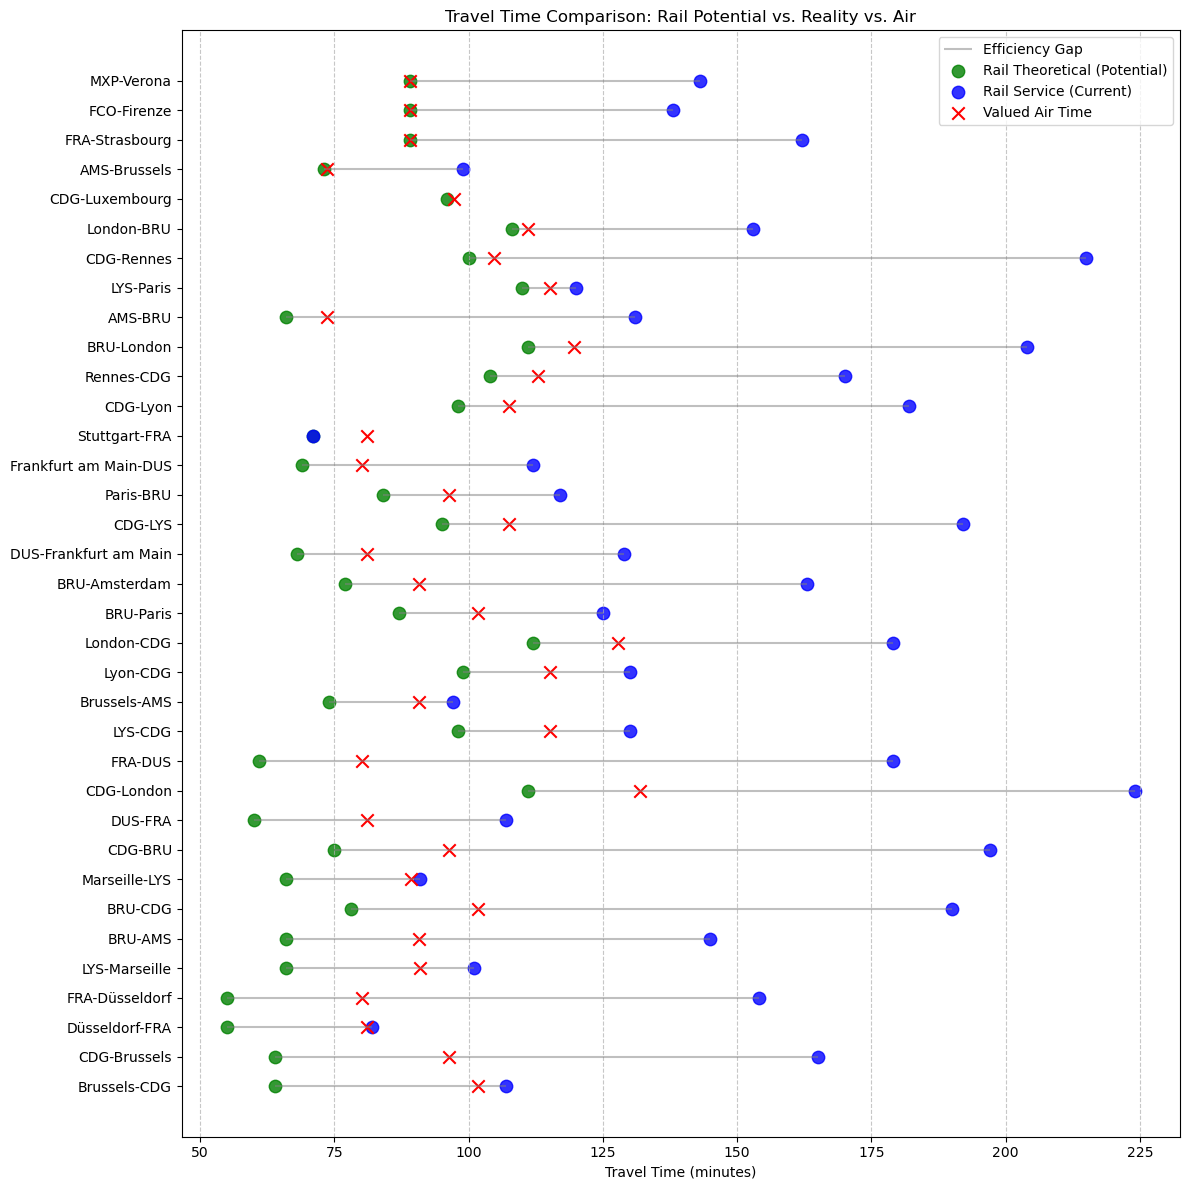

In [35]:
plt.figure(figsize=(12, 12))
plt.hlines(y=plot_df['Route Name'], xmin=plot_df['Rail Theoretical Travel Time'], xmax=plot_df['Rail Service Travel Time'], color='grey', alpha=0.5, label='Efficiency Gap')

# Plot points
plt.scatter(plot_df['Rail Theoretical Travel Time'], plot_df['Route Name'], color='green', label='Rail Theoretical (Potential)', s=80, alpha=0.8)
plt.scatter(plot_df['Rail Service Travel Time'], plot_df['Route Name'], color='blue', label='Rail Service (Current)', s=80, alpha=0.8)
plt.scatter(plot_df['Valued Air Travel Time'], plot_df['Route Name'], color='red', marker='x', label='Valued Air Time', s=80)

plt.xlabel('Travel Time (minutes)')
plt.title('Travel Time Comparison: Rail Potential vs. Reality vs. Air')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

### Time Difference Distribution by Country

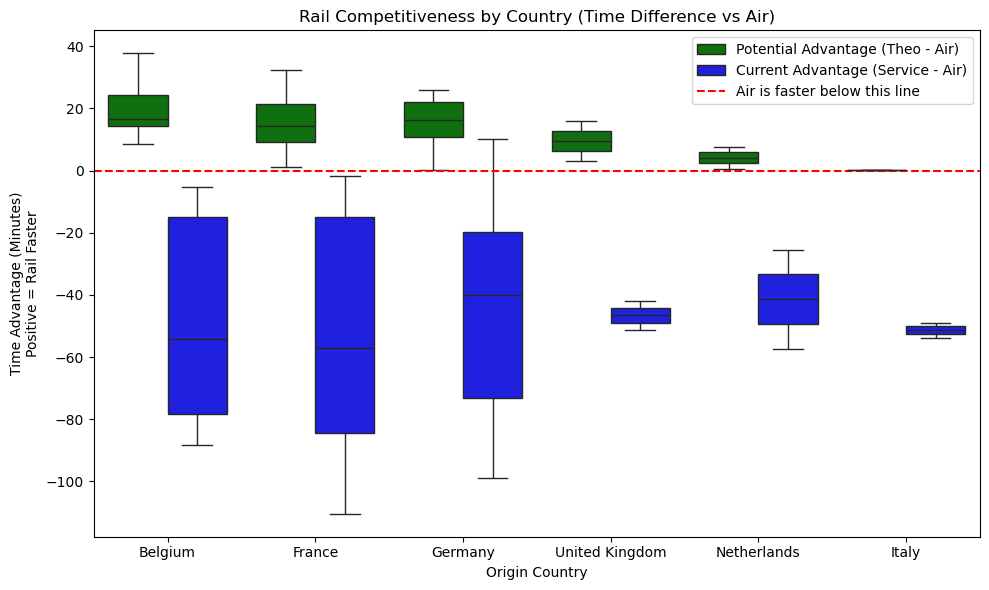

In [36]:
plt.figure(figsize=(10, 6))
melted = plot_df.melt(id_vars=['Route Name', 'Origin Country'], value_vars=['Theoretical Time Difference', 'Service Time Difference'], var_name='Metric', value_name='Minutes')

melted['Metric'] = melted['Metric'].replace({
    'Theoretical Time Difference': 'Potential Advantage (Theo - Air)',
    'Service Time Difference': 'Current Advantage (Service - Air)'
})

sns.boxplot(data=melted, x='Origin Country', y='Minutes', hue='Metric', palette=['green', 'blue'])
plt.axhline(0, color='red', linestyle='--', label='Air is faster below this line')
plt.title('Rail Competitiveness by Country (Time Difference vs Air)')
plt.ylabel('Time Advantage (Minutes)\nPositive = Rail Faster')
plt.legend()
plt.tight_layout()

### Scatter of Theoretical vs Service Time

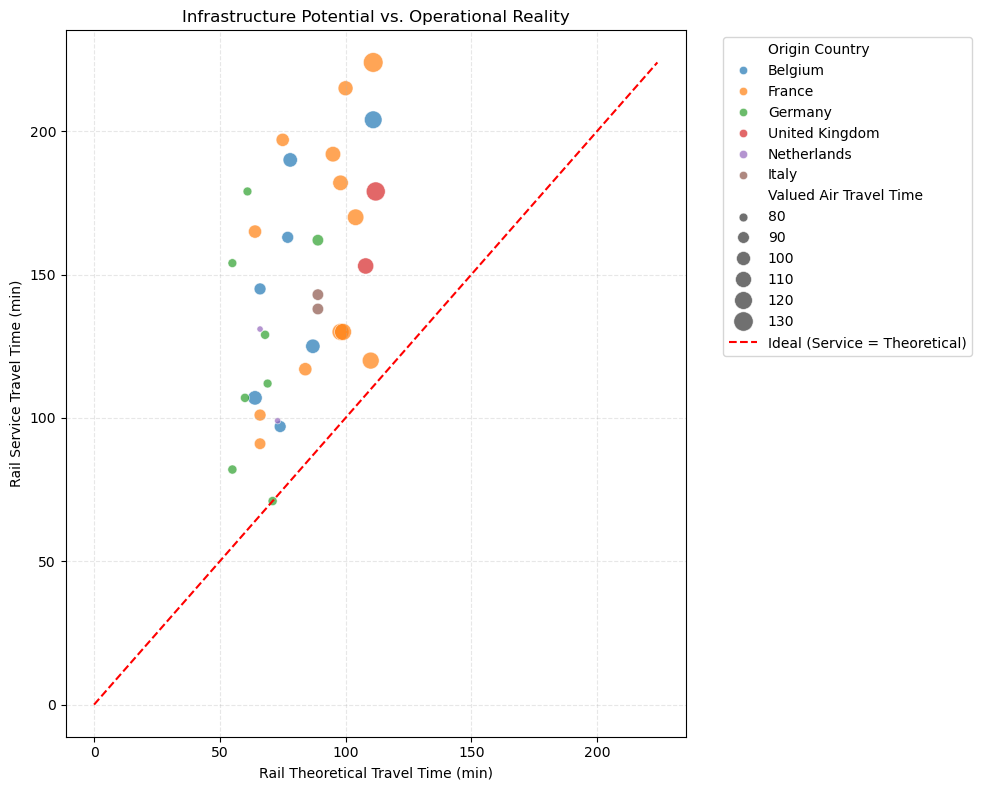

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='Rail Theoretical Travel Time', y='Rail Service Travel Time', hue='Origin Country', size='Valued Air Travel Time', sizes=(20, 200), alpha=0.7)

max_val = max(plot_df['Rail Theoretical Travel Time'].max(), plot_df['Rail Service Travel Time'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal (Service = Theoretical)')
plt.xlabel('Rail Theoretical Travel Time (min)')
plt.ylabel('Rail Service Travel Time (min)')
plt.title('Infrastructure Potential vs. Operational Reality')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()